<h1><center><font color = 'blue'>AMSUA N18 CH14 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

### Import

In [2]:
df = pd.read_hdf('Data/amsua12_n18_ch14.h5')
print(len(df))

1447004


### Compute Sensitivity

In [3]:
df['SENSITIVITY'] = df['IMPACT']/df['OMF']

### Keep only outliers

In [4]:
y_mean = df['SENSITIVITY'].mean()
y_std = df['SENSITIVITY'].std()

df['is_outlier'] = df['SENSITIVITY'].map(lambda x: abs((x - y_mean)) > 3 * y_std)

outliers = df[df['is_outlier'] == True].reset_index(drop=True)

print(len(outliers))

24834


### Split ML inputs and outputs

In [5]:
X = outliers.drop(['DATETIME', 'IMPACT', 'OMF', 'SENSITIVITY', 'is_outlier'], axis=1)
y = outliers['SENSITIVITY']

cols_2D = [col for col in X.columns if not any(char.isdigit() for char in col)]

### Explore y (sensitivity)

In [6]:
y.describe()

count    2.483400e+04
mean    -6.751343e-08
std      2.919396e-06
min     -1.098445e-05
25%     -2.491019e-06
50%     -2.012806e-06
75%      2.464930e-06
max      9.279972e-06
Name: SENSITIVITY, dtype: float64

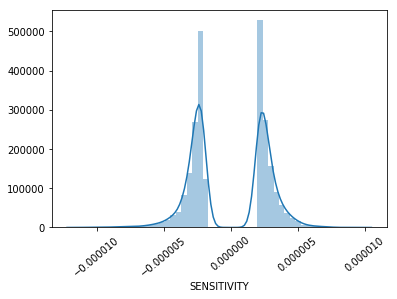

In [7]:
sns.distplot(y)
plt.xticks(rotation=40)
plt.show()

In [8]:
abs(y).describe()

count    2.483400e+04
mean     2.775418e-06
std      9.078401e-07
min      1.998037e-06
25%      2.188867e-06
50%      2.478802e-06
75%      3.012266e-06
max      1.098445e-05
Name: SENSITIVITY, dtype: float64

### y correlations with X variables 

In [9]:
y_corr = X.corrwith(y, axis=0)
print('\n5 largest corr with y:\n{}'.format(y_corr.nlargest()))
print('\n5 smallest corr with y:\n{}'.format(y_corr.nsmallest()))


5 largest corr with y:
u_0.04           0.078923
v_1.868          0.069062
u_0.057          0.066945
v_5.632          0.062422
ozone_427.673    0.059563
dtype: float64

5 smallest corr with y:
lon            -0.113798
LONGITUDE      -0.113790
ozone_21.761   -0.108369
ozone_26.049   -0.092635
tv_26.049      -0.088501
dtype: float64


### Train and predict (Linear Regression & Gradient Boosting)

In [10]:
# split train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [11]:
# train Linear Regression
lr = LinearRegression()
lr.fit(X_train[cols_2D], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
# train Gradient Boosting
gbm = lgbm.LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.1, random_state=10)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=('train', 'test'),
    eval_metric='l2',
    early_stopping_rounds=20,
    feature_name=X_train.columns.tolist(),
    verbose=False
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=10,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [13]:
# predict LR
lr_pred = lr.predict(X_test[cols_2D])

In [14]:
# predict GBM
gbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

### Results

#### Linear Regression

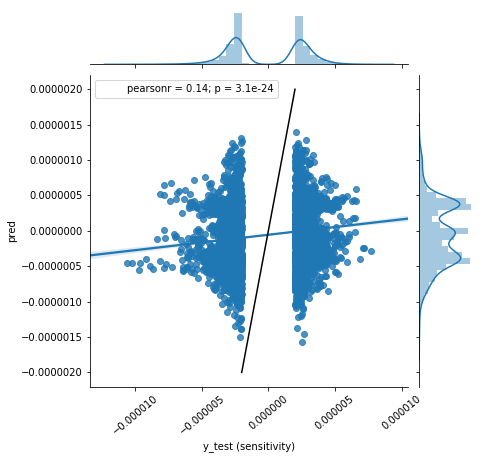

In [25]:
ax = sns.jointplot(x=y_test , y=lr_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# add bissectrice (in black)
plt.plot([-0.000002, 0.000002], [-0.000002, 0.000002], 'k-')
# prevent x axis labels overlapping
plt.xticks(rotation=40)
plt.show()

#### Gradient Boosting

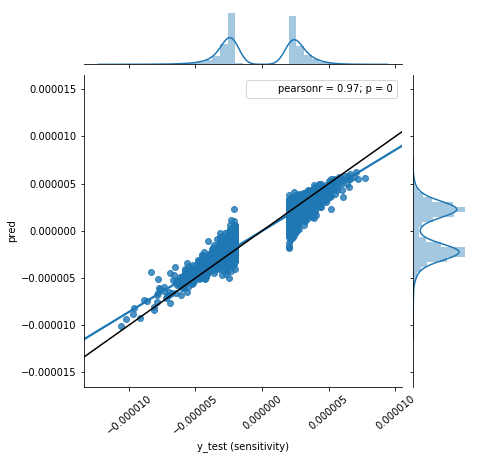

In [26]:
ax = sns.jointplot(x=y_test , y=gbm_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# add bissectrice (in black)
plt.plot([-0.000015, 0.000015], [-0.000015, 0.000015], 'k-')
# prevent x axis labels overlapping
plt.xticks(rotation=40)
plt.show()

#### Mean Squared Error

In [17]:
print('Only zeros MSE: {0:.4g}' .format(mean_squared_error(y_test, [0]*len(y_test))))
print('AMSUA LR MSE:   {0:.4g}' .format(mean_squared_error(y_test, lr_pred)))
print('AMSUA GBM MSE:  {0:.4g}' .format(mean_squared_error(y_test, gbm_pred)))

Only zeros MSE: 8.381e-12
AMSUA LR MSE:   8.199e-12
AMSUA GBM MSE:  6.179e-13


#### Compute statistics about real sensitivity and pred sensitivity ratio

In [18]:
ratio = pd.Series(y_test/gbm_pred)
ratio.describe()

count    4967.000000
mean        1.429227
std        11.717247
min      -161.136203
25%         0.980421
50%         1.133179
75%         1.377783
max       677.900444
Name: SENSITIVITY, dtype: float64

#### Display ratio pdf

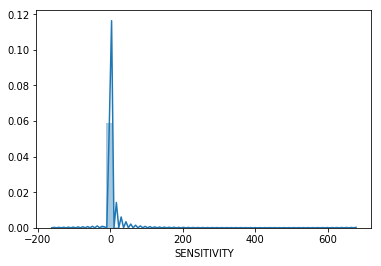

In [19]:
ax = sns.distplot(ratio, norm_hist=True)

#### % of ratio values between ]-5:5[

In [20]:
print('{0:.2f}%' .format(len(ratio[(ratio > -5) & (ratio < 5)])/len(ratio)*100))

97.83%


#### Display ratio between ]-5:5[ pdf

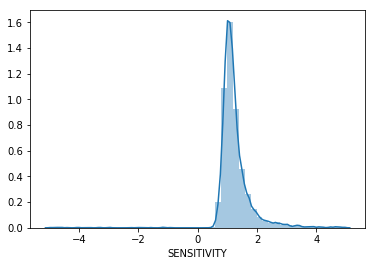

In [21]:
filtered = ratio[(ratio > -5) & (ratio < 5)]
ax = sns.distplot(filtered)

#### % of ratio values between ]0.5:1.5[

In [22]:
print('{0:.2f}%' .format(len(ratio[(ratio > 0.5) & (ratio < 1.5)])/len(ratio)*100))

79.91%


#### % of ratio negative sign

In [23]:
print('{0:.2f}%' .format(len(ratio[ratio < 0])/len(ratio)*100))

1.29%


#### % of ratio values ≈ 0

In [31]:
print('{0:.2f}%' .format(len(ratio[abs(ratio) < 1e-3])/len(ratio)*100))

0.00%
